# Plot of endolichenic fungi assembly data

This Notebook plots data for the low-coverage short read assemblies generated by the Fungiflow pipeline for endolichenic fungi.

There are several PairGrid plots describing the assembly metrics by sequencing batch and fungal Class.
A Principal Components analysis (PCA) is then performed to identify relationships between this data.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import prince

In [2]:
df = pd.read_csv("../ELF_master_results.csv")
# add batch number to the dataframe
df.loc[(df['Assembly'] <= 147), 'pooled_library'] = '1'
df.loc[(df['Assembly'] > 147), 'pooled_library'] = '2'
df["complete_buscos"] = df["BUSCO - C"].str.split("(").str[1].str.split("%").str[0]
df["actual_coverage"] = (df["# left"]*300)/44200000
df.head()

,Assembly,estimated_coverage,# contigs (>= 0 bp),# contigs (>= 1000 bp),# contigs (>= 5000 bp),# contigs (>= 10000 bp),# contigs (>= 25000 bp),# contigs (>= 50000 bp),Total length (>= 0 bp),Total length (>= 1000 bp),...,Host_Order,Host_Family,Host_Genus,Host_Species,Photobiont,Growth_form,Macroclimate,pooled_library,complete_buscos,actual_coverage
0,48,19.85,18650.0,7139.0,3268.0,1301.0,80.0,1.0,46702950.0,44181167.0,...,Peltigerales,Lobariaceae,Crocodia,rubella,Tripartite,Foliose,"Cool, sub-humid",1,94.51,18.684781
1,127,2.02,8205.0,6344.0,2252.0,667.0,12.0,0.0,32307499.0,31293355.0,...,Lecanorales,Parmeliaceae,Parmotrema,austrocetratum,Green,Foliose,"Mild, humid",1,94.66,14.733618
2,88,3.26,21619.0,13914.0,2293.0,269.0,1.0,0.0,49048021.0,44617122.0,...,Lecanorales,Parmeliaceae,Menegazzia,neozelandica,Green,Foliose,"Cold, sub-humid",1,88.34,17.760665
3,41,16.48,7669.0,5107.0,2779.0,1355.0,176.0,12.0,41008469.0,40123702.0,...,Lecanorales,Sphaerophoraceae,Sphaerophorus,stereocauloides,Green,Fruticose,"Cool, humid",1,92.61,15.568283
4,93,8.18,10018.0,6922.0,2873.0,1001.0,39.0,3.0,40324782.0,39050212.0,...,Lecanorales,Parmeliaceae,Menegazzia,neozelandica,Green,Foliose,"Cold, sub-humid",1,83.16,8.454774


In [39]:
display(df[["Assembly", "actual_coverage"]].sort_values(by="actual_coverage", ascending=False))

,Assembly,actual_coverage
98,160,95.904808
5,170,72.354462
34,31,61.818061
108,203,61.164041
66,262,60.913079
...,...,...
375,332,NaN
376,352,NaN
377,356,NaN
378,360,NaN


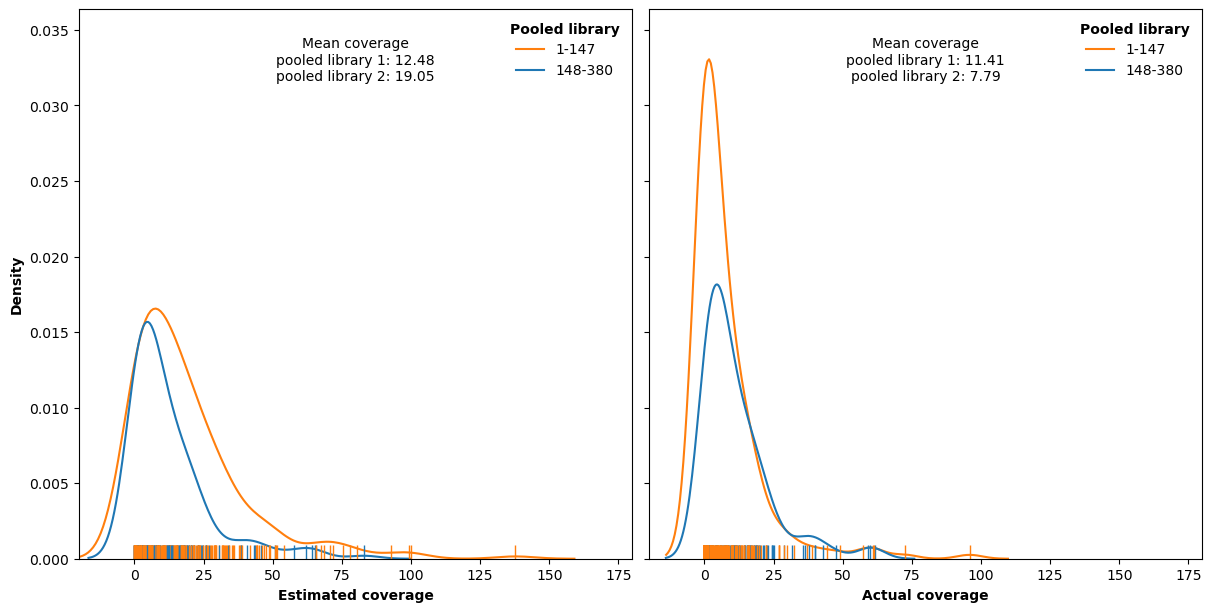

In [3]:
est_1_avg = df[df["pooled_library"] == "1"]["estimated_coverage"].mean()
est_2_avg = df[df["pooled_library"] == "2"]["estimated_coverage"].mean()
act_1_avg = df[df["pooled_library"] == "1"]["actual_coverage"].mean()
act_2_avg = df[df["pooled_library"] == "2"]["actual_coverage"].mean()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, layout="constrained")
sns.kdeplot(data=df, x="estimated_coverage", ax=axes[0], hue="pooled_library")
sns.rugplot(data=df, x="estimated_coverage", ax=axes[0], hue="pooled_library")
sns.kdeplot(data=df, x="actual_coverage", ax=axes[1], hue="pooled_library")
sns.rugplot(data=df, x="actual_coverage", ax=axes[1], hue="pooled_library")
axes[0].legend(["1-147", "148-380"], title = 'Pooled library', loc = 'best', frameon = False, title_fontproperties={'weight':"bold"}, markerscale=4)
axes[1].legend(["1-147", "148-380"], title = 'Pooled library', loc = 'best', frameon = False, title_fontproperties={'weight':"bold"}, markerscale=4)
axes[0].set_xlim(-20, 180)
axes[1].set_xlim(-20, 180)
axes[0].set_ylabel("Density", fontproperties={'weight':"bold"})
axes[0].set_xlabel("Estimated coverage", fontproperties={'weight':"bold"})
axes[1].set_xlabel("Actual coverage", fontproperties={'weight':"bold"})
axes[0].text(x=0.5, y=0.95, s=f"Mean coverage\npooled library 1: {round(est_1_avg, 2)}\npooled library 2: {round(est_2_avg, 2)}", ha='center', va='top', transform=axes[0].transAxes)
axes[1].text(x=0.5, y=0.95, s=f"Mean coverage\npooled library 1: {round(act_1_avg, 2)}\npooled library 2: {round(act_2_avg, 2)}", ha='center', va='top', transform=axes[1].transAxes)
plt.savefig("read_coverages.svg", format="svg", bbox_inches='tight')

In [4]:
# function to categorize BGC length data
def cat(x):
    if x < 0.1:
        return "<0.1"
    elif x < 0.5:
        return "0.1-0.5"
    elif x < 1:
        return "0.5-1"
    elif x < 1.5:
        return "1-1.5"
    elif x < 2:
        return "1.5-2"
    elif x < 2.5:
        return "2-2.5"
    elif x < 3:
        return "2.5-3"
    elif x >= 3:
        return ">3"
    else:
        return "<0.1"

In [5]:
# take subset of dataframe
df3 = df[["actual_coverage", "# contigs", "pooled_library", "N50", "L50", "Total length", "BGC_count", "total_BGC_length", "complete_buscos"]]
df3["dataset"] = "ELF"
df3.head()

C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\1757957842.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["dataset"] = "ELF"


,actual_coverage,# contigs,pooled_library,N50,L50,Total length,BGC_count,total_BGC_length,complete_buscos,dataset
0,18.684781,8394.0,1,8854.0,1572.0,45064903.0,111.0,1430229.0,94.51,ELF
1,14.733618,7270.0,1,6712.0,1480.0,31964532.0,87.0,975509.0,94.66,ELF
2,17.760665,18266.0,1,3737.0,3941.0,47773956.0,86.0,853685.0,88.34,ELF
3,15.568283,5700.0,1,11623.0,1067.0,40552559.0,81.0,1286784.0,92.61,ELF
4,8.454774,7987.0,1,7870.0,1568.0,39826919.0,79.0,933549.0,83.16,ELF


In [6]:
df3["BGC total length (Mbp)"] = df3["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
df3["Assembly length (Mbp)"] = df3["Total length"].div(1000000)
df3 = df3.rename(columns={"complete_buscos":"Complete BUSCOS (%)"})
df3 = df3.drop(columns=['total_BGC_length', "Total length"])
df3.reindex()
df3.to_csv("metrics_dataset.csv")
df3.head()

C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\3077882108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["BGC total length (Mbp)"] = df3["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\3077882108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Assembly length (Mbp)"] = df3["Total length"].div(1000000)


,actual_coverage,# contigs,pooled_library,N50,L50,BGC_count,Complete BUSCOS (%),dataset,BGC total length (Mbp),Assembly length (Mbp)
0,18.684781,8394.0,1,8854.0,1572.0,111.0,94.51,ELF,1-1.5,45.064903
1,14.733618,7270.0,1,6712.0,1480.0,87.0,94.66,ELF,0.5-1,31.964532
2,17.760665,18266.0,1,3737.0,3941.0,86.0,88.34,ELF,0.5-1,47.773956
3,15.568283,5700.0,1,11623.0,1067.0,81.0,92.61,ELF,1-1.5,40.552559
4,8.454774,7987.0,1,7870.0,1568.0,79.0,83.16,ELF,0.5-1,39.826919


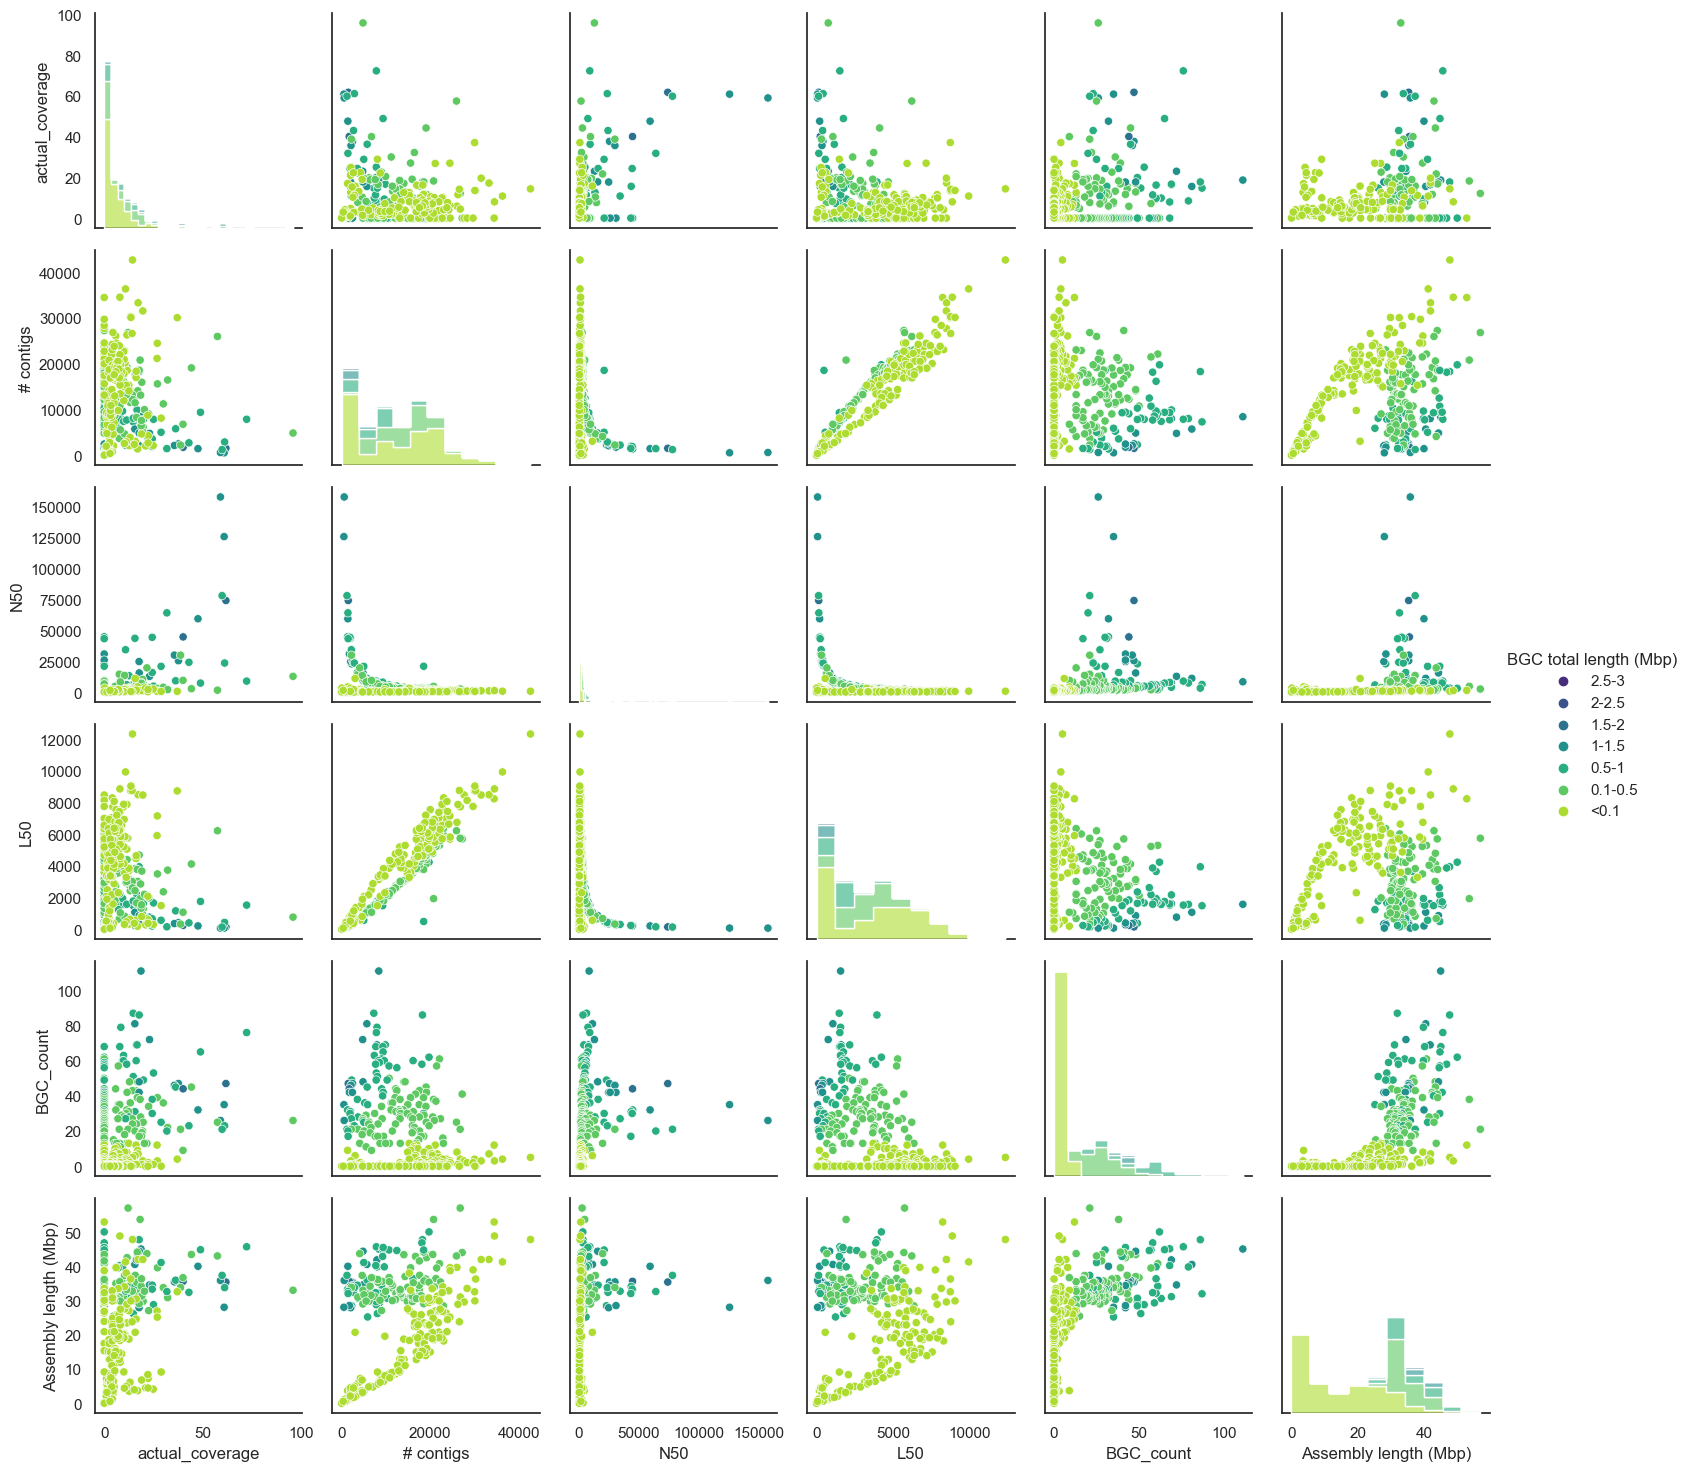

In [7]:
sns.set_palette('viridis')
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style(style='white')
sns.set_context("notebook", font_scale=1)

# Use PairGrid to get different markers for 'dataset' and colours for 'BGC total length (Mbp)'
g = sns.PairGrid(data=df3, hue="BGC total length (Mbp)", hue_order=["2.5-3","2-2.5","1.5-2","1-1.5","0.5-1","0.1-0.5","<0.1"], palette="viridis")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.6)
g.map_offdiag(sns.scatterplot)
g.add_legend(title=None)
plt.savefig("ELF_all_v_all_metrics.svg", format="svg")
plt.show()

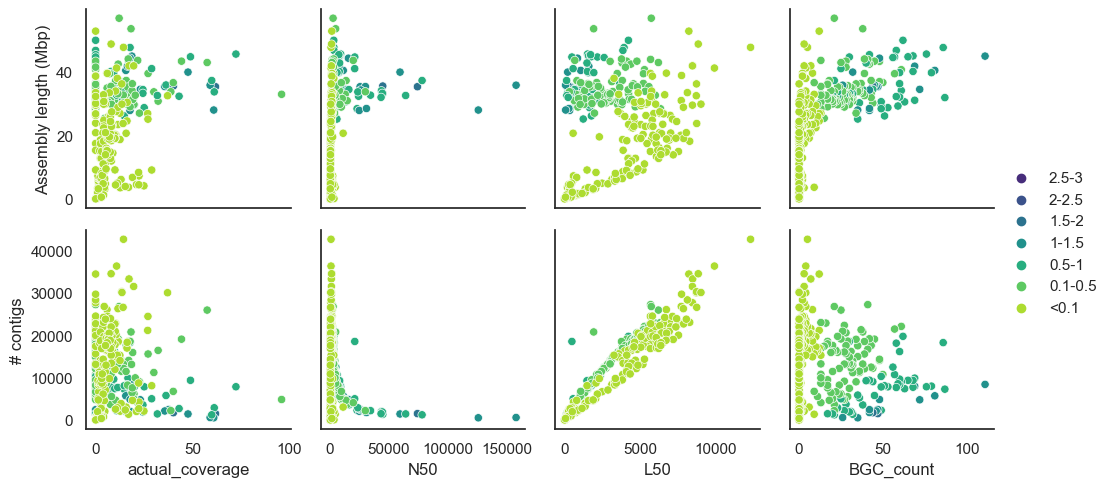

In [9]:
g = sns.PairGrid(data=df3, \
                 y_vars=["Assembly length (Mbp)", "# contigs"], \
                 x_vars=["actual_coverage", "N50", "L50", "BGC_count"],
                 hue="BGC total length (Mbp)", \
                 hue_order=["2.5-3","2-2.5","1.5-2","1-1.5","0.5-1","0.1-0.5","<0.1"], \
                 palette="viridis")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.8)
g.map_offdiag(sns.scatterplot)
g.add_legend(title="", adjust_subtitles=True)
plt.savefig("ELF_assembly_length_v_metrics.svg", format="svg")
plt.show()

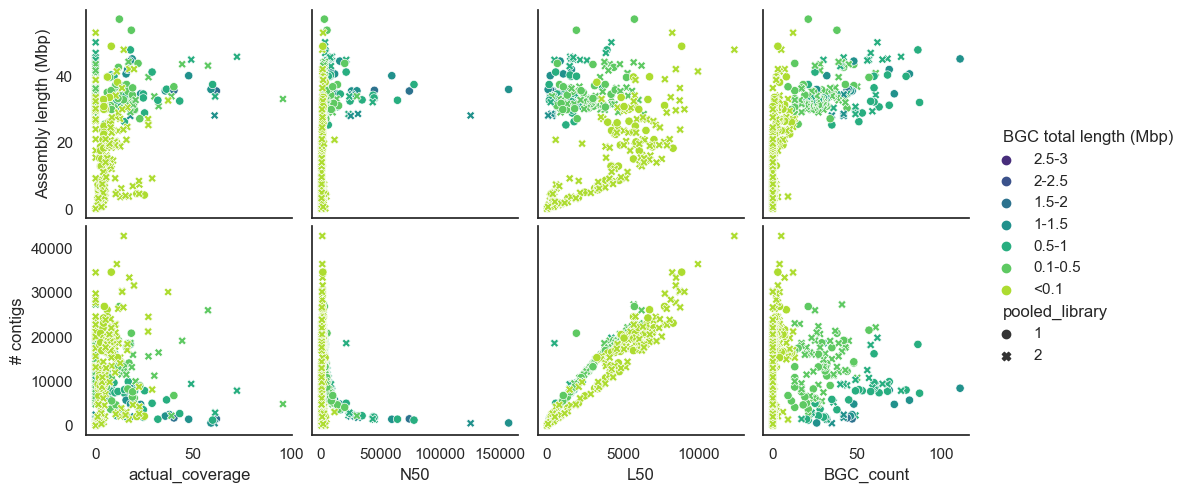

In [10]:
g = sns.PairGrid(data=df3, \
                 y_vars=["Assembly length (Mbp)", "# contigs"], \
                 x_vars=["actual_coverage", "N50", "L50", "BGC_count"],
                 hue="BGC total length (Mbp)", \
                 hue_order=["2.5-3","2-2.5","1.5-2","1-1.5","0.5-1","0.1-0.5","<0.1"], \
                 palette="viridis")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.8)
g.map_offdiag(sns.scatterplot, style=df3["pooled_library"])
g.add_legend(title="", adjust_subtitles=True)
g.tight_layout()
plt.savefig("ELF_assembly_length_v_metrics_by_batch.svg", format="svg")
plt.show()

In [11]:
df4 = df[["actual_coverage", "# contigs", "pooled_library", "N50", "L50", "Total length", "BGC_count", "total_BGC_length", "complete_buscos", "Subject Name", "isolate_class"]]
df4["BGC total length (Mbp)"] = df4["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
df4["Assembly length (Mbp)"] = df4["Total length"].div(1000000)
df4["Species"] = df4["Subject Name"].str.split(" ", expand=True)[0]
df4["Class"] = df4["isolate_class"]
df4 = df4.drop(columns=['Subject Name', 'total_BGC_length', "Total length", "isolate_class"])
df4

C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\4153698447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["BGC total length (Mbp)"] = df4["total_BGC_length"].div(1000000).apply(lambda x: cat(x))
C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\4153698447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["Assembly length (Mbp)"] = df4["Total length"].div(1000000)
C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\4153698447.py:4: SettingWithCopyWarning: 
A value is trying to be set 

,actual_coverage,# contigs,pooled_library,N50,L50,BGC_count,complete_buscos,BGC total length (Mbp),Assembly length (Mbp),Species,Class
0,18.684781,8394.0,1,8854.0,1572.0,111.0,94.51,1-1.5,45.064903,Anthostomelloides,Sordariomycetes
1,14.733618,7270.0,1,6712.0,1480.0,87.0,94.66,0.5-1,31.964532,Penicillium,Eurotiomycetes
2,17.760665,18266.0,1,3737.0,3941.0,86.0,88.34,0.5-1,47.773956,Anthostomelloides,Sordariomycetes
3,15.568283,5700.0,1,11623.0,1067.0,81.0,92.61,1-1.5,40.552559,Amphirosellinia,Sordariomycetes
4,8.454774,7987.0,1,7870.0,1568.0,79.0,83.16,0.5-1,39.826919,Amphirosellinia,Sordariomycetes
...,...,...,...,...,...,...,...,...,...,...,...
375,NaN,NaN,2,NaN,NaN,NaN,NaN,<0.1,NaN,NaN,NaN
376,NaN,NaN,2,NaN,NaN,NaN,NaN,<0.1,NaN,NaN,NaN
377,NaN,NaN,2,NaN,NaN,NaN,NaN,<0.1,NaN,NaN,NaN
378,NaN,NaN,2,NaN,NaN,NaN,NaN,<0.1,NaN,NaN,NaN


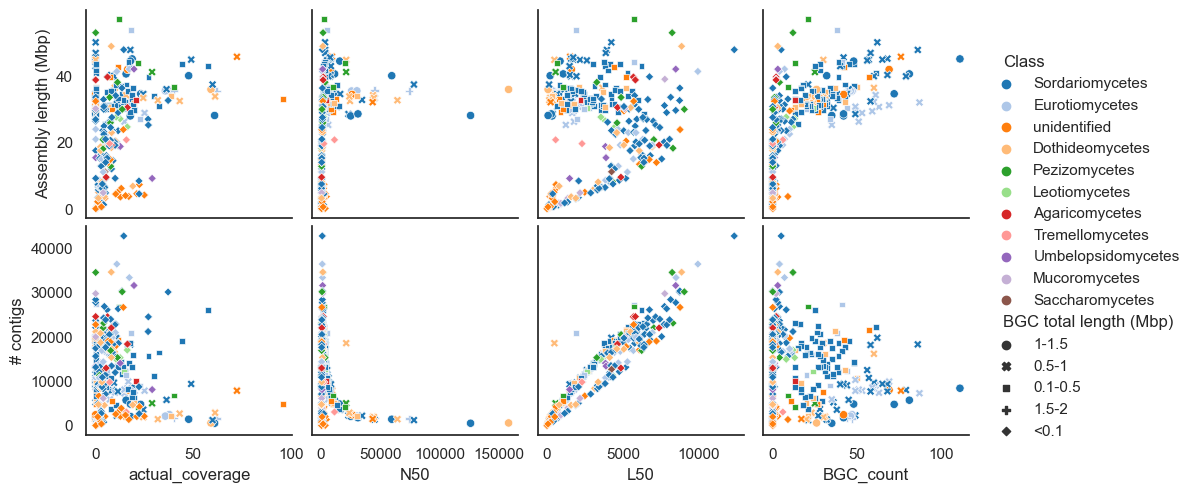

In [23]:
sns.set_style(style='white')

g = sns.PairGrid(data=df4, \
                 y_vars=["Assembly length (Mbp)", "# contigs"], \
                 x_vars=["actual_coverage", "N50", "L50", "BGC_count"],
                 hue="Class", palette="tab20")
g.map_diag(sns.histplot, color=".3", multiple="stack", element="step", alpha=0.8)
g.map_offdiag(sns.scatterplot, style=df4["BGC total length (Mbp)"])
g.add_legend(title="", adjust_subtitles=True)
g.tight_layout()
plt.savefig("ELF_assembly_length_v_metrics_Class.svg", format="svg")
plt.show()

## Principal components analysis of fungal Class

    - PCA is first performed using Prince
    - PCA is repeated with scikit-learn to verfiy the results and to prepeare seaborn-compatible plots

In [13]:
df5 = df4.drop(columns=["Species", "BGC total length (Mbp)", "pooled_library"])
df5["Class"] = df5["Class"].dropna()
df5 = df5.fillna(0)
display(df5)

,actual_coverage,# contigs,N50,L50,BGC_count,complete_buscos,Assembly length (Mbp),Class
0,18.684781,8394.0,8854.0,1572.0,111.0,94.51,45.064903,Sordariomycetes
1,14.733618,7270.0,6712.0,1480.0,87.0,94.66,31.964532,Eurotiomycetes
2,17.760665,18266.0,3737.0,3941.0,86.0,88.34,47.773956,Sordariomycetes
3,15.568283,5700.0,11623.0,1067.0,81.0,92.61,40.552559,Sordariomycetes
4,8.454774,7987.0,7870.0,1568.0,79.0,83.16,39.826919,Sordariomycetes
...,...,...,...,...,...,...,...,...
375,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0
376,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0
377,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0
378,0.000000,0.0,0.0,0.0,0.0,0,0.000000,0


In [14]:
df6 = df[["actual_coverage", '# contigs', 'N50', 'L50', 'BGC_count', 'BUSCO - C', 'Total length', 'total_BGC_length', 'pooled_library']]
df6["complete_buscos"] = df6["BUSCO - C"].str.split("(").str[1].str.split("%").str[0]
df6 = df6.drop(columns=["BUSCO - C"])
df6 = df6.fillna(0)
df6

C:\Users\styleske\AppData\Local\Temp\ipykernel_11832\516263509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6["complete_buscos"] = df6["BUSCO - C"].str.split("(").str[1].str.split("%").str[0]


,actual_coverage,# contigs,N50,L50,BGC_count,Total length,total_BGC_length,pooled_library,complete_buscos
0,18.684781,8394.0,8854.0,1572.0,111.0,45064903.0,1430229.0,1,94.51
1,14.733618,7270.0,6712.0,1480.0,87.0,31964532.0,975509.0,1,94.66
2,17.760665,18266.0,3737.0,3941.0,86.0,47773956.0,853685.0,1,88.34
3,15.568283,5700.0,11623.0,1067.0,81.0,40552559.0,1286784.0,1,92.61
4,8.454774,7987.0,7870.0,1568.0,79.0,39826919.0,933549.0,1,83.16
...,...,...,...,...,...,...,...,...,...
375,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0
376,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0
377,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0
378,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0


In [15]:
pca = prince.PCA(
    n_components=4,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(df6)
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.927,43.63%,43.63%
1,2.380,26.45%,70.08%
2,0.956,10.62%,80.70%
3,0.934,10.38%,91.09%


In [16]:
pca.scree_plot()

alt.Chart(...)

The turning point occurs at component 2, suggesting that most of the variation can be explained by the first 2 components.

In [17]:
pca.transform(df6).head()

component,0,1,2,3
0,5.584790,-0.883576,-1.572402,-1.763097
1,3.922080,-0.936263,-1.164362,-1.654810
2,4.170583,0.850647,-0.749139,-1.615411
3,4.565575,-1.215589,-1.066805,-1.485481
4,3.647585,-0.662910,-1.172651,-1.738688


In [18]:
pca.column_coordinates_

component,0,1,2,3
variable,,,,
actual_coverage,0.616745,-0.122356,0.508856,0.363380
# contigs,0.148800,0.976847,0.116783,0.008386
N50,0.615080,-0.370294,0.394314,0.350578
L50,-0.008164,0.958370,0.204053,0.040285
BGC_count,0.865963,-0.030487,-0.368876,-0.192122
Total length,0.828064,0.503190,-0.066318,-0.042435
total_BGC_length,0.911945,-0.257078,-0.110473,-0.011076
pooled_library,-0.236445,0.178776,-0.523836,0.798111
complete_buscos,0.907166,0.057465,-0.243445,-0.044475


In [19]:
pca.plot(
    df6,
    x_component=0,
    y_component=1,
    show_rows=True,
    show_columns=True
)

alt.LayerChart(...)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

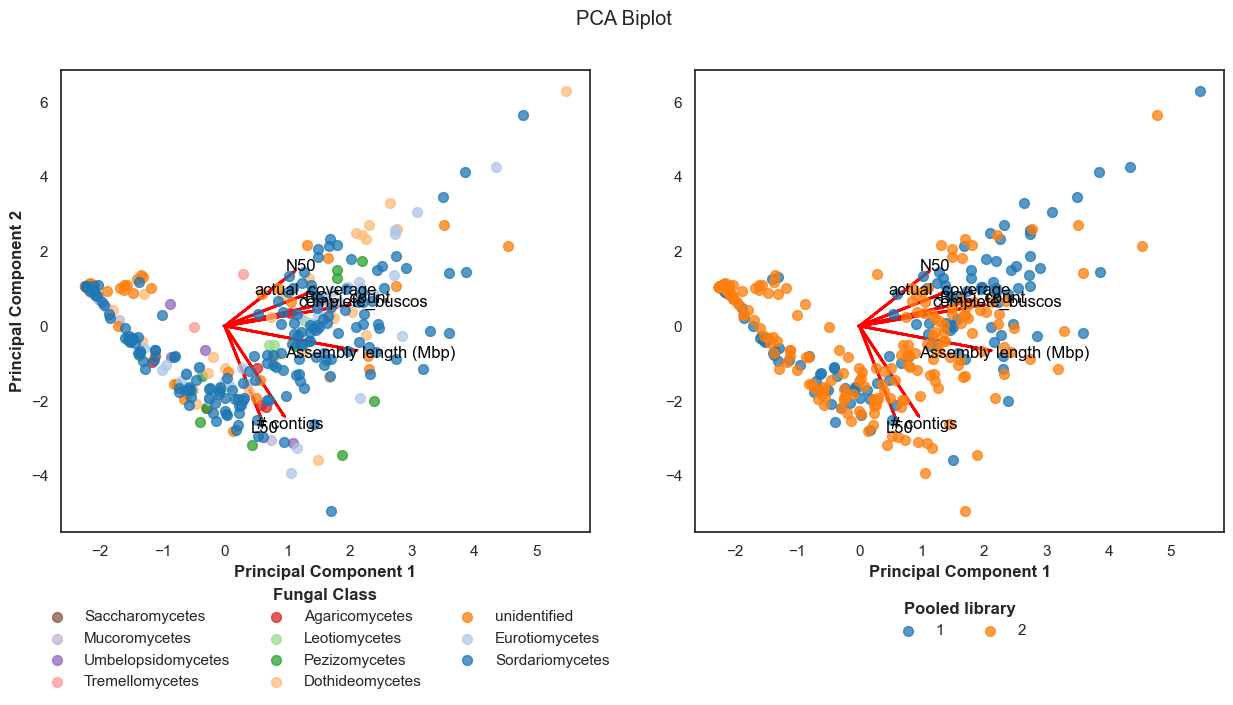

In [25]:
## prepare data
df7 = df4.drop(columns=["Species", "BGC total length (Mbp)", "pooled_library"])
df7["Class"] = df7["Class"].fillna("Unknown")
df7 = df7.fillna(0)
df8 = df4.drop(columns=["Species", "BGC total length (Mbp)", "Class"])
df8 = df8.fillna(0)
df8 = df8[["actual_coverage", '# contigs', 'N50', 'L50', 'BGC_count', 'complete_buscos', 'Assembly length (Mbp)', 'pooled_library']]

## Perform PCAs
# separate the features from the target variable and the class column
X1 = df7.iloc[:, :-1].values
y1 = df7.iloc[:, -1].values
# standardize the data
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
# perform PCA
pca1 = PCA()
principalComponents1 = pca1.fit_transform(X1)
# create a biplot
loading_scores1 = pd.DataFrame(pca1.components_.T, columns=[f'PC{i}' for i in range(1, pca1.n_components_+1)], index=df7.columns[:-1])

# separate the features from the target variable and the class column
X2 = df8.iloc[:, :-1].values
y2 = df8.iloc[:, -1].values
# standardize the data
X2 = scaler.fit_transform(X2)
# perform PCA
pca2 = PCA()
principalComponents2 = pca2.fit_transform(X2)
# create a biplot
loading_scores2 = pd.DataFrame(pca2.components_.T, columns=[f'PC{i}' for i in range(1, pca2.n_components_+1)], index=df8.columns[:-1])

## Plot each of the PCA biplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))

# assign colours for each marker in each dataset
# for fungal Class
classes = df7["Class"].unique()
tab20 = sns.color_palette("tab20", 20)
tab10 = sns.color_palette("tab10", 20)
n = len(classes) - 2
colors1 = {}
while n >= 0:
    colors1[classes[n]] = tab20[n]
    n-=1
# for datasets
colors2 = {"1":tab10[0], "2":tab10[1]}

# plot the principal components for fungal Class
for i, feature in enumerate(df7.columns[:-1]):
    ax1.arrow(0, 0, loading_scores1.loc[feature, 'PC1']*4, loading_scores1.loc[feature, 'PC2']*4, color='red', alpha=1, linewidth=2)
    ax1.text(loading_scores1.loc[feature, 'PC1']*4.4, loading_scores1.loc[feature, 'PC2']*4.4, feature, color='black', ha='center', va='center')
for class_name, color in colors1.items():
    indices = np.where(y1 == class_name)[0]
    ax1.scatter(principalComponents1[indices, 0], principalComponents1[indices, 1], s=50, alpha=0.75, c=color, label=class_name)
ax1.legend(title="Fungal Class", loc='lower center', bbox_to_anchor=(0.5, -0.37), frameon=False, ncol=3, title_fontproperties={'weight':"bold"})
ax1.set_xlabel('Principal Component 1', fontproperties={'weight':"bold"})
ax1.set_ylabel('Principal Component 2', fontproperties={'weight':"bold"})

# plot the principal components for dataset
for i, feature in enumerate(df8.columns[:-1]):
    ax2.arrow(0, 0, loading_scores2.loc[feature, 'PC1']*4, loading_scores2.loc[feature, 'PC2']*4, color='red', alpha=1, linewidth=2)
    ax2.text(loading_scores2.loc[feature, 'PC1']*4.4, loading_scores2.loc[feature, 'PC2']*4.4, feature, color='black', ha='center', va='center')
for class_name, color in colors2.items():
    indices = np.where(y2 == class_name)[0]
    ax2.scatter(principalComponents2[indices, 0], principalComponents2[indices, 1], s=50, alpha=0.75, c=color, label=class_name)
ax2.legend(title="Pooled library", loc='lower center', bbox_to_anchor=(0.5, -0.26), frameon=False, ncol=3, title_fontproperties={'weight':"bold"})
ax2.set_xlabel('Principal Component 1', fontproperties={'weight':"bold"})
fig.suptitle('PCA Biplot')
fig.savefig("PCA_biplot_dataset_fclass.svg", format="svg", bbox_inches='tight')
plt.show()
